# MetOpts Lab4

##### imports

In [1782]:
import torch
import numpy as np
import torch.optim

from torch.autograd import Variable
pd.set_option('display.float_format', '{:.15e}'.format)
import pandas as pd
import matplotlib.pyplot as plot
import scipy.optimize
from scipy.optimize import line_search

import warnings

warnings.filterwarnings('ignore')

## Задание 1.   
Изучить использование PyTorch для автоматического вычисления градиента.

---

Возьмем какую-то простенькую функцию, например `f(x) = 2(x+3)^2 + 5`  
Тогда градиент - `4(x+3)`

In [1783]:
def f_simple(x):
    return 2 * torch.pow(x + 3, 2) + 5

Попробуем посчитать градиент при помощи соответствующей функции из `PyTorch`

In [1784]:
xs = torch.tensor([i for i in range(-5, 5)], dtype=torch.float64)
print(xs)
print(f_simple(xs))
print(f"gradient {torch.gradient(f_simple(xs))}")

tensor([-5., -4., -3., -2., -1.,  0.,  1.,  2.,  3.,  4.], dtype=torch.float64)
tensor([ 13.,   7.,   5.,   7.,  13.,  23.,  37.,  55.,  77., 103.],
       dtype=torch.float64)
gradient (tensor([-6., -4.,  0.,  4.,  8., 12., 16., 20., 24., 26.], dtype=torch.float64),)


Везде получаются правильные значения градиента, за исключением границ массива. Это связано с особенностью работы `torch.gradient`, где градиент считается как `dy[i] = (y[i+1] - y[i-1]) / (2*dx)`. Что с `i = 0`? `y[-1]` не знаем, поэтому считается как `dy[0] = (y[1] - y[0]) / (dx)`. Это хоть и не критично, но не совсем то, что мы хотели бы (не сходится с формулой).. То же самое с `i = n`.

При большом желании, можно воспользоваться параметром `edge_order=2`, для решения этой проблемы. Он для граничных случаев считает градиент по-другому. А именно как `dy[0] = -(3*y[0] - 4*y[1] + y[2]) / (2*dx)` (литералли код из сурса). Для `i = n` по аналогии. По формуле сходится и мы рады. А почему это работает, оставим читателю в качестве упражнения.

Рассмотрим нахождение градиента функции `f(x0 .. x4)` в некоторой точке. Для применения `.backward()` требуется надичие параметра `requires_grad=True` у тензора точки. Затем можно получать `.grad` у данных тензоров.

In [1785]:
def f(x):
    return 1 + 3*x[0] - 4*x[1]**2 + 2*x[2]**3 + 5*x[3]*torch.sin(x[4])
    
n = 5
x0 = np.random.randn(n)


xs = tuple(map(lambda xi: torch.tensor(xi, dtype=torch.float64, requires_grad=True), x0))

y0 = f(xs)
y0.backward()

print(f"grad f (xs) = {[xi.grad for xi in xs]}")

grad f (xs) = [tensor(3., dtype=torch.float64), tensor(-0.0907, dtype=torch.float64), tensor(0.0187, dtype=torch.float64), tensor(-2.7802, dtype=torch.float64), tensor(-4.0627, dtype=torch.float64)]


## Задание 2.  
Изучить использование вариантов SGD (torch.optim) из PyTorch. Исследовать эффективность и сравнить с собственными реализациями из 2 работы.

---

Общий код SGD, функции ошибки и ее градиента из Лаб. 2

In [1786]:
EPOCHES = 1000
EPS = 1e-8

def loss_func(x, y, batch_size=100):
    return lambda c, id: sum(
        (y[id * batch_size : (id + 1) * batch_size + 1]
        - (c[1] * x[id * batch_size : (id + 1)
        * batch_size + 1] + c[0])) ** 2
        )

def grad(c, f, id, delta=1e-8):
    return np.array([
        (f(c + [delta, 0], id) - f(c - [delta, 0], id)) / (2 * delta),
        (f(c + [0, delta], id) - f(c - [0, delta], id)) / (2 * delta)
    ])

def sgd(start, lr, next_result, loss, batch_size, n):
    points = []
    
    c = start
    diff = loss(c, 0)
    for epoch in range(EPOCHES):
        points.append(c)
        
        c = next_result(c, 0, lr, loss)
        prev_diff, diff = diff, loss(c, 0)
        if abs(diff - prev_diff) < EPS:
            break
    
    return np.array(points)

Классы методов-модивикаций SGD из Лаб. 2

In [1787]:
class AdaGrad:
    def __init__(self):
        self.eps = 1e-8
        self.g = np.array([0., 0.])

    def __call__(self, c, batch_id, lr, loss):
        gr = grad(c, loss, batch_id)
        
        self.g += gr ** 2
        return c - gr * lr / (np.sqrt(self.g) + self.eps)

class RMSProp:
    def __init__(self, gamma):
        self.eps = 1e-8
        self.g = np.array([0., 0.])
        self.gamma = gamma
        
    def __call__(self, c, batch_id, lr, loss):
        gr = grad(c, loss, batch_id)

        self.g = self.g * self.gamma + (1 - self.gamma) * (gr ** 2)
        return c - gr * lr / (np.sqrt(self.g) + self.eps)
    
class Adam:
    def __init__(self, beta, gamma):
        self.eps = 1e-8
        self.beta = beta
        self.gamma = gamma
        self.s1 = np.array([0., 0.])
        self.s2 = np.array([0., 0.])
    
    def __call__(self, c, batch_id, lr, loss):
        gr = grad(c, loss, batch_id)
        self.s1 = self.beta * self.s1 + (1- self.beta) * gr
        self.s2 = self.gamma * self.s2 + (1 - self.gamma) * (gr ** 2)
        return c - lr * self.s1 / (np.sqrt(self.s2) + self.eps)

Генерация случайного набора точек, аппроксимируемых прямой, и применение нормализации данных.

In [1788]:
x = 20. * np.random.random_sample((100,))
y = np.asarray([5. * x_i + (np.random.random_sample() * 2 - 1) * 10. for x_i in x])

def scaled(x):
    mn = min(x)
    mx = max(x)
    return np.array([(xi - mn) / (mx - mn) for xi in x])

x = scaled(x)
y = scaled(y)

loss_summary = lambda c: loss_func(x,y)(c,0)

Функции отрисовки контуров отдельных методов и визуализации сравнения модификаций SGD с их аналогами из PyTorch. (Возврощает дополнительную информацию в табличке Pandas, ее также рассмотрим)

In [1789]:
def draw_plot(ax, points, title = ""):
    mi_x = min(points[:, 0])
    ma_x = max(points[:, 0])
    mi_y = min(points[:, 1])
    ma_y = max(points[:, 1])
    offset_x = abs(ma_x - mi_x) / 2
    offset_y = abs(ma_x - mi_y) / 5
    
    X, Y = np.meshgrid(
        np.linspace(mi_x - offset_x, ma_x + offset_x, 1000),
        np.linspace(mi_y - offset_y, ma_y + offset_y, 1000)
    )

    def fair_fn(c0, c1):
        return sum((y - c1 * x - c0) ** 2 for x, y in zip(x, y))
    
    ax.contour(X, Y, fair_fn(X, Y), levels=sorted(list(set([fair_fn(*p) for p in points]))))
    ax.plot(points[:, 0], points[:, 1], "o-", color="red")
    if title:
        ax.set_title(title)

def compare_results(torch_points, our_points, name, draw=True):
    cfs = [torch_points[-1], our_points[-1]]
    data = [[f"torch_{name}", len(torch_points), loss_summary(cfs[0])],[f"our_{name}", len(our_points), loss_summary(cfs[1])]]
    if (draw):
        fig, (ax0, ax1, ax2) = plot.subplots(3,1)
        fig.set_size_inches(20,30)
        
        ax0.scatter(x, y)
        ax0.set_title(f"Аппроксимация {name}")
        ax0.plot(x, x * cfs[0][1] + cfs[0][0], label = "torch")
        ax0.plot(x, x * cfs[1][1] + cfs[1][0], label = "our")
        ax0.legend()
        
        draw_plot(ax1, torch_points, title = f"Траектория спуска torch_{name}")
        draw_plot(ax2, our_points, title = f"Траектория спуска our_{name}")
        plot.show()
    return pd.DataFrame(data, columns=["name", "epochs", "loss"])

Общий код и подготовка модели SGD от PyTorch.

In [1790]:
xs = Variable(torch.tensor(x[:, np.newaxis]).float())
ys = Variable(torch.tensor(y[:, np.newaxis]).float())

loss_fn = torch.nn.MSELoss()
model = torch.nn.Linear(1, 1)

def optimize(optimizer):
    prev, cur = 0, 2 * EPS
    points = []
    output = None

    for epoch in range(EPOCHES):
        optimizer.zero_grad()
        output  = model(xs)
        loss = loss_fn(output, ys)
        loss.backward()
        optimizer.step()
        prev, cur = cur, loss.data
        points.append([model.bias.detach().numpy()[0], model.weight.detach().numpy()[0][0]])
        if abs(prev - cur) < EPS:
            break
    return np.array(points)

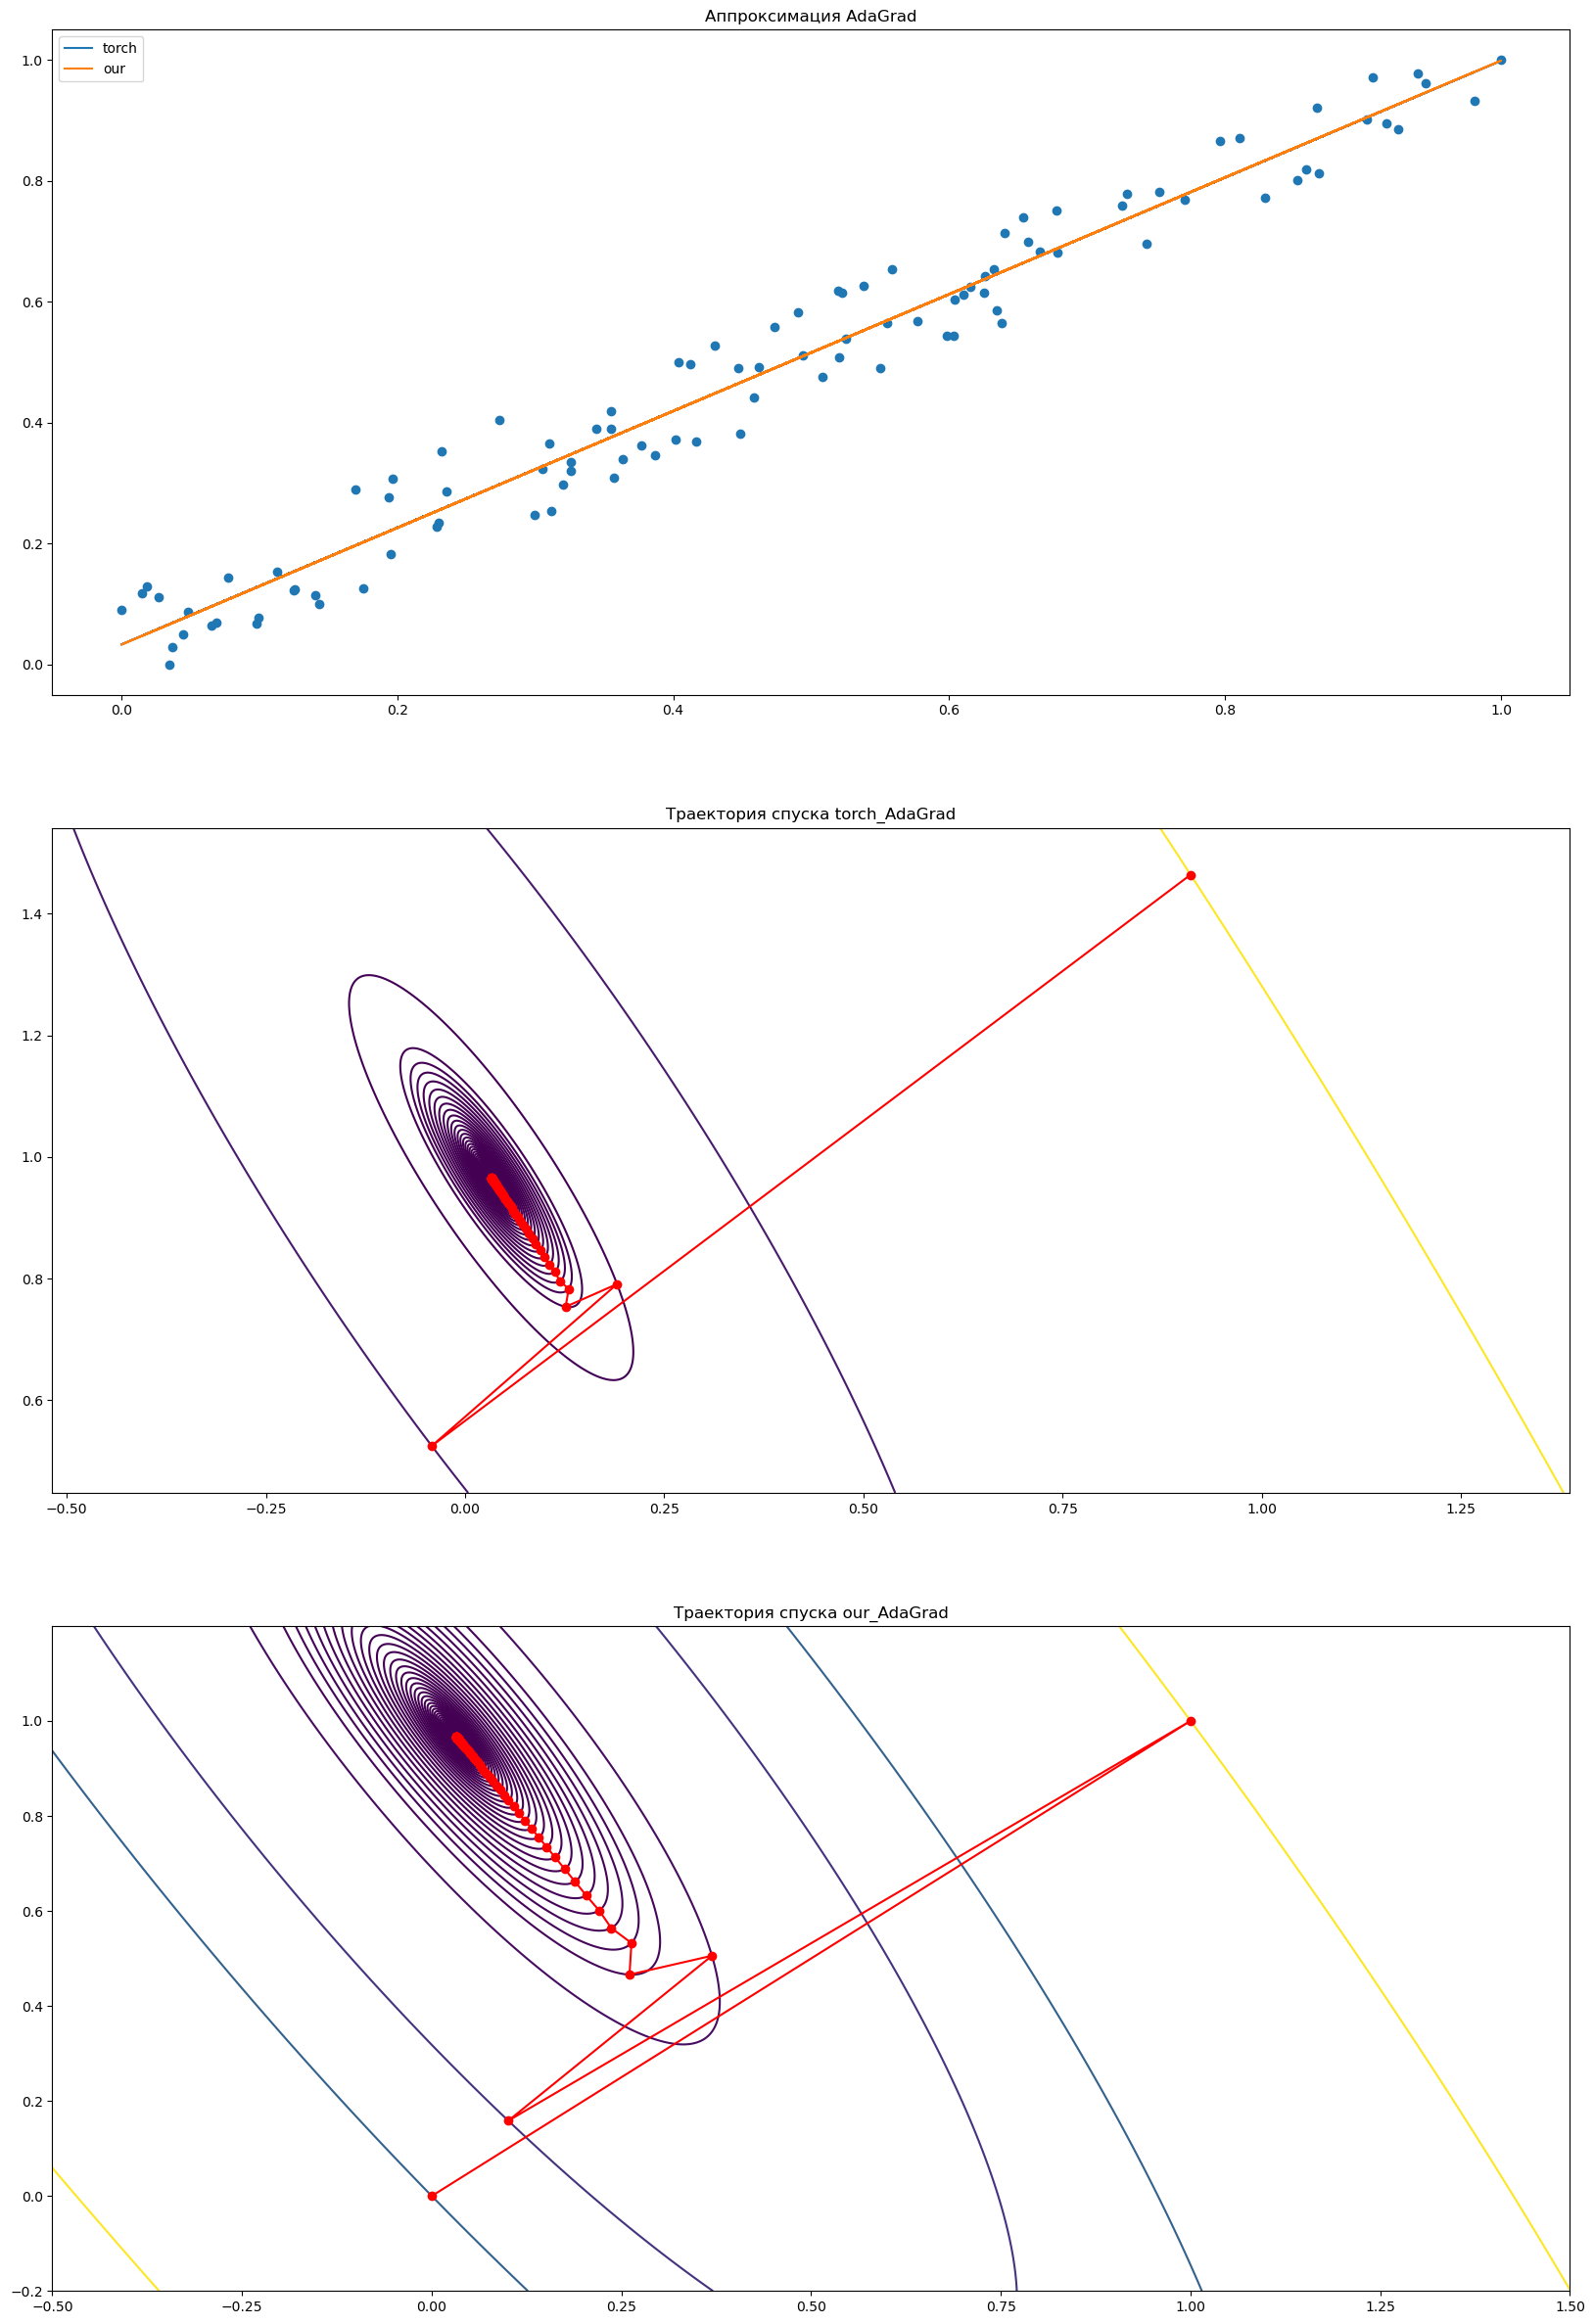

In [1791]:
shared_lr = 1
model = torch.nn.Linear(1, 1)
torch_adagrad_res = optimize(torch.optim.Adagrad(model.parameters(), lr = shared_lr))
our_adagrad_res = sgd(np.array([0., 0.]), shared_lr, AdaGrad(), loss_func(x, y), 100, 100)
df_adagrad = compare_results(torch_adagrad_res, our_adagrad_res, "AdaGrad")

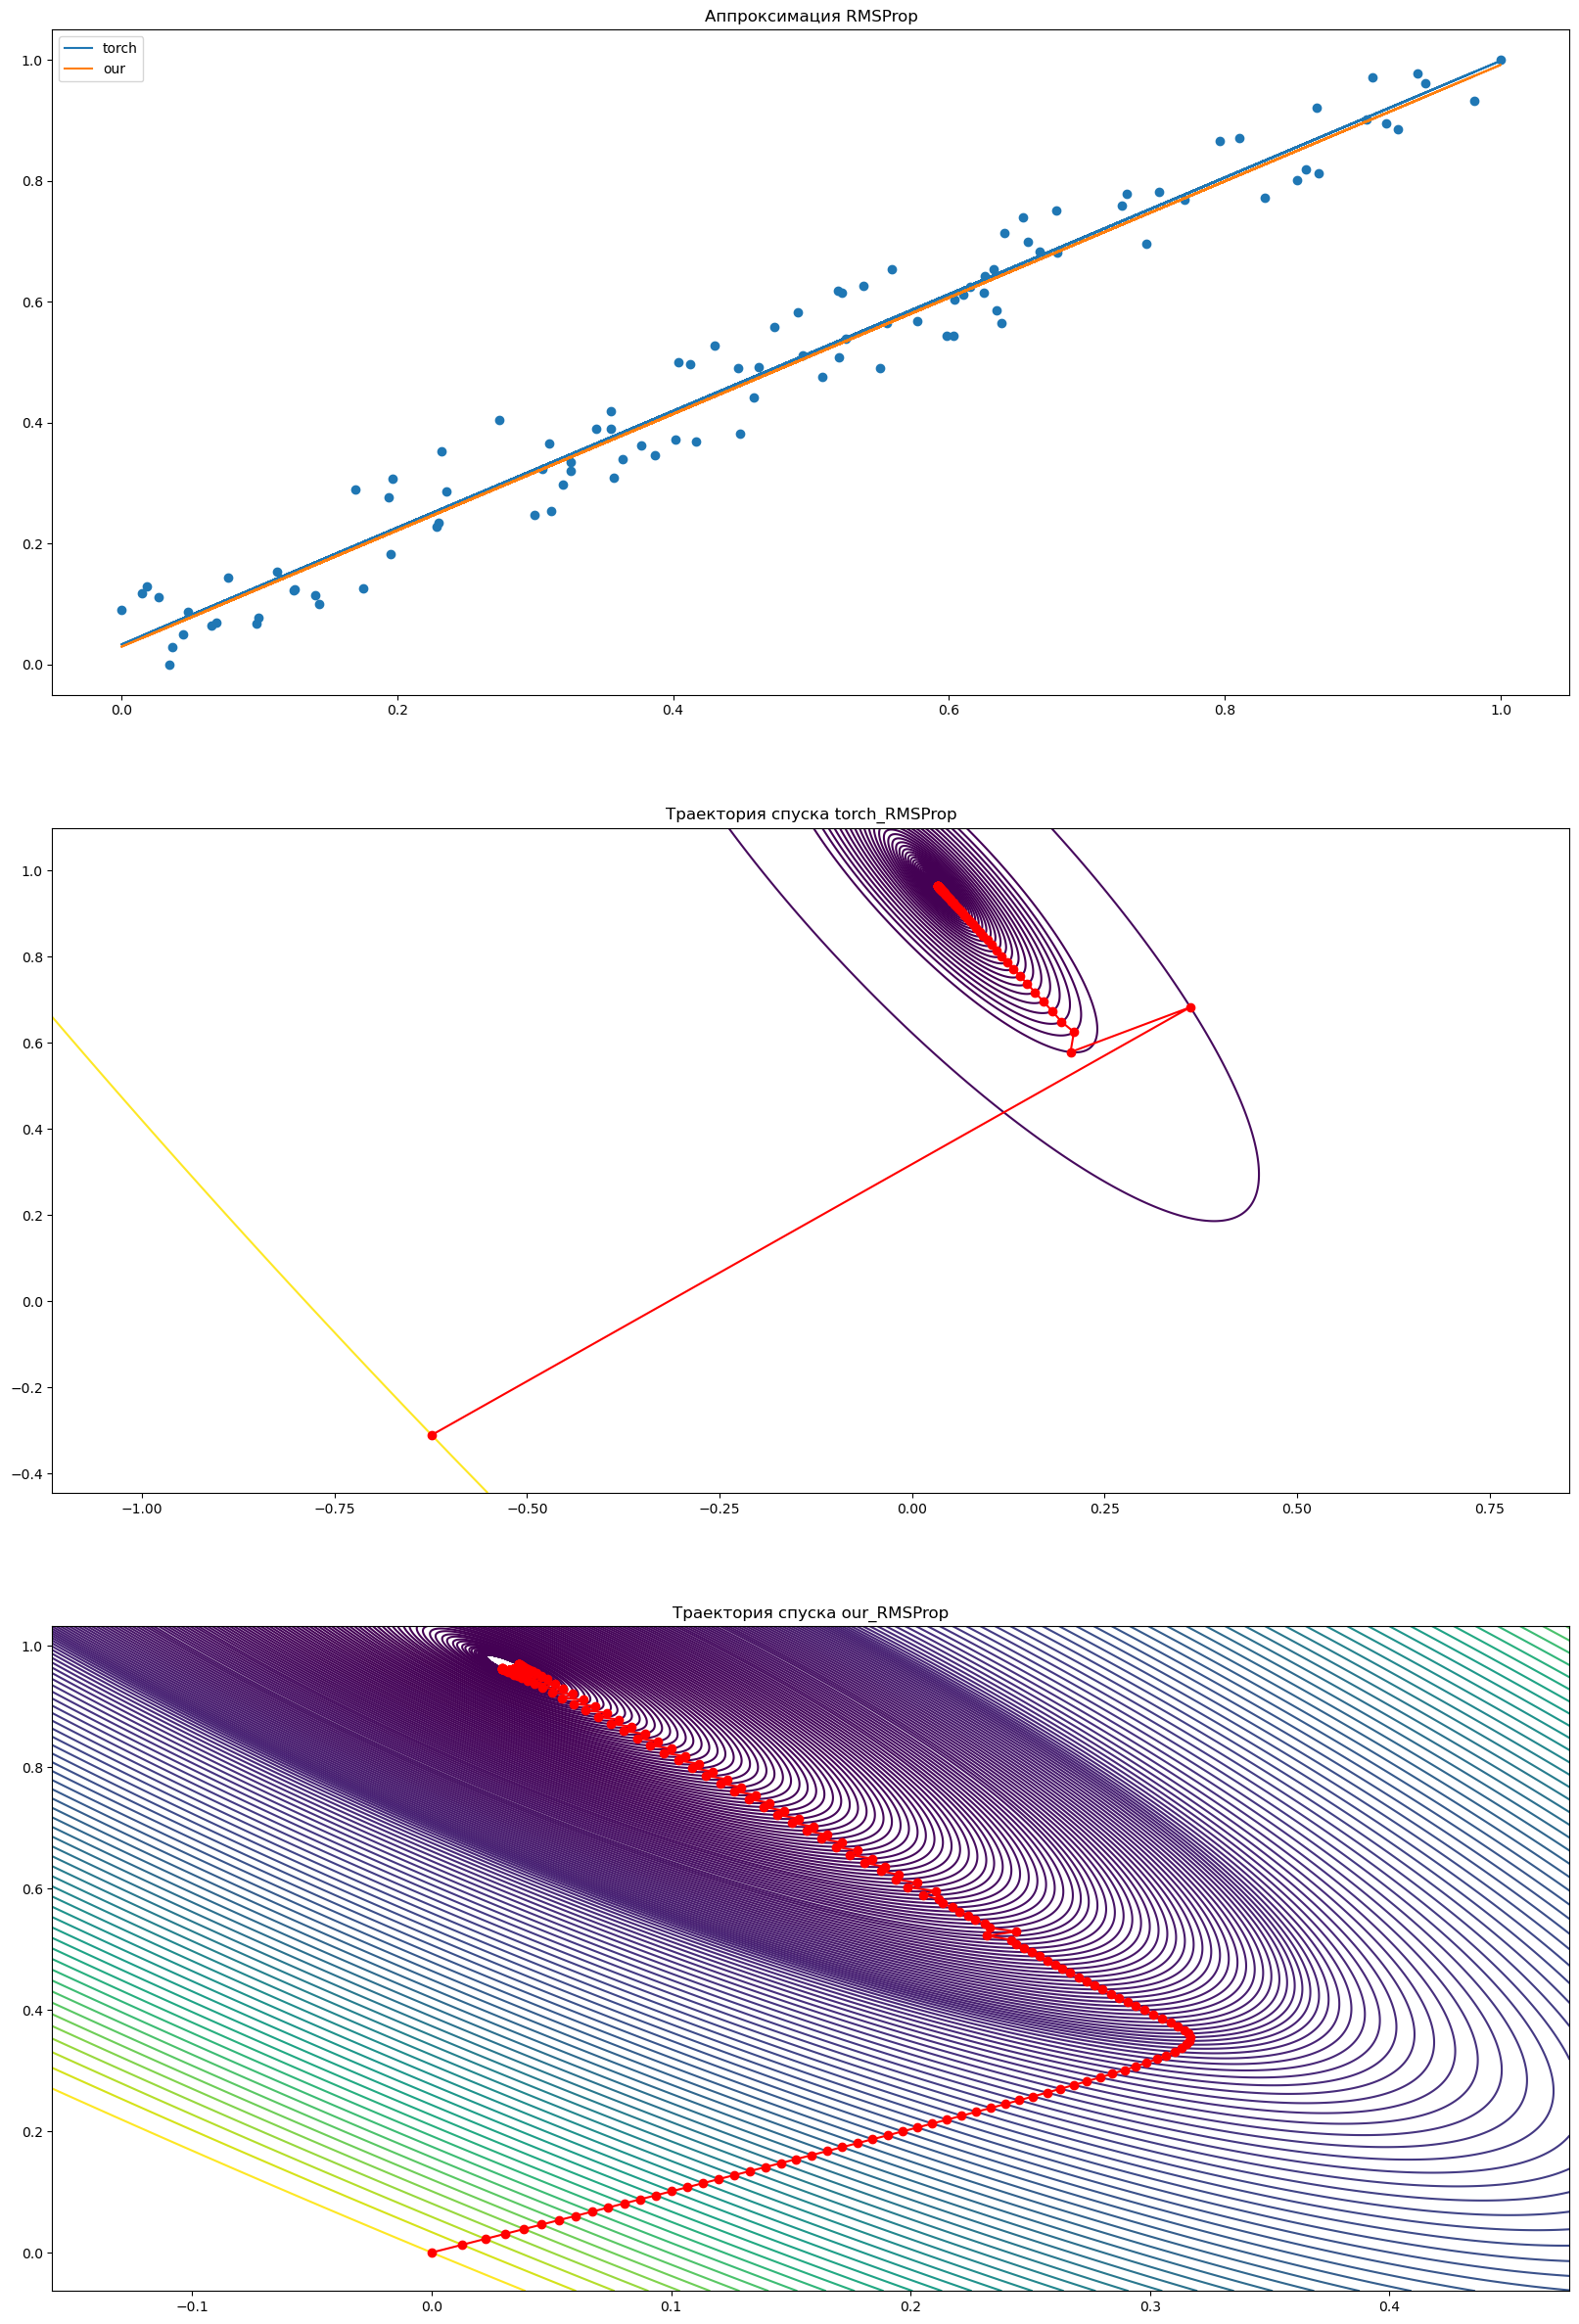

In [1792]:
shared_lr = 0.01
model = torch.nn.Linear(1, 1)
torch_rmsprop_res = optimize(torch.optim.RMSprop(model.parameters(), lr = 0.1))
our_rmsprop_res = sgd(np.array([0., 0.]), 0.007, RMSProp(0.7), loss_func(x, y), 100, 100)
df_rmsprop = compare_results(torch_rmsprop_res, our_rmsprop_res, "RMSProp")

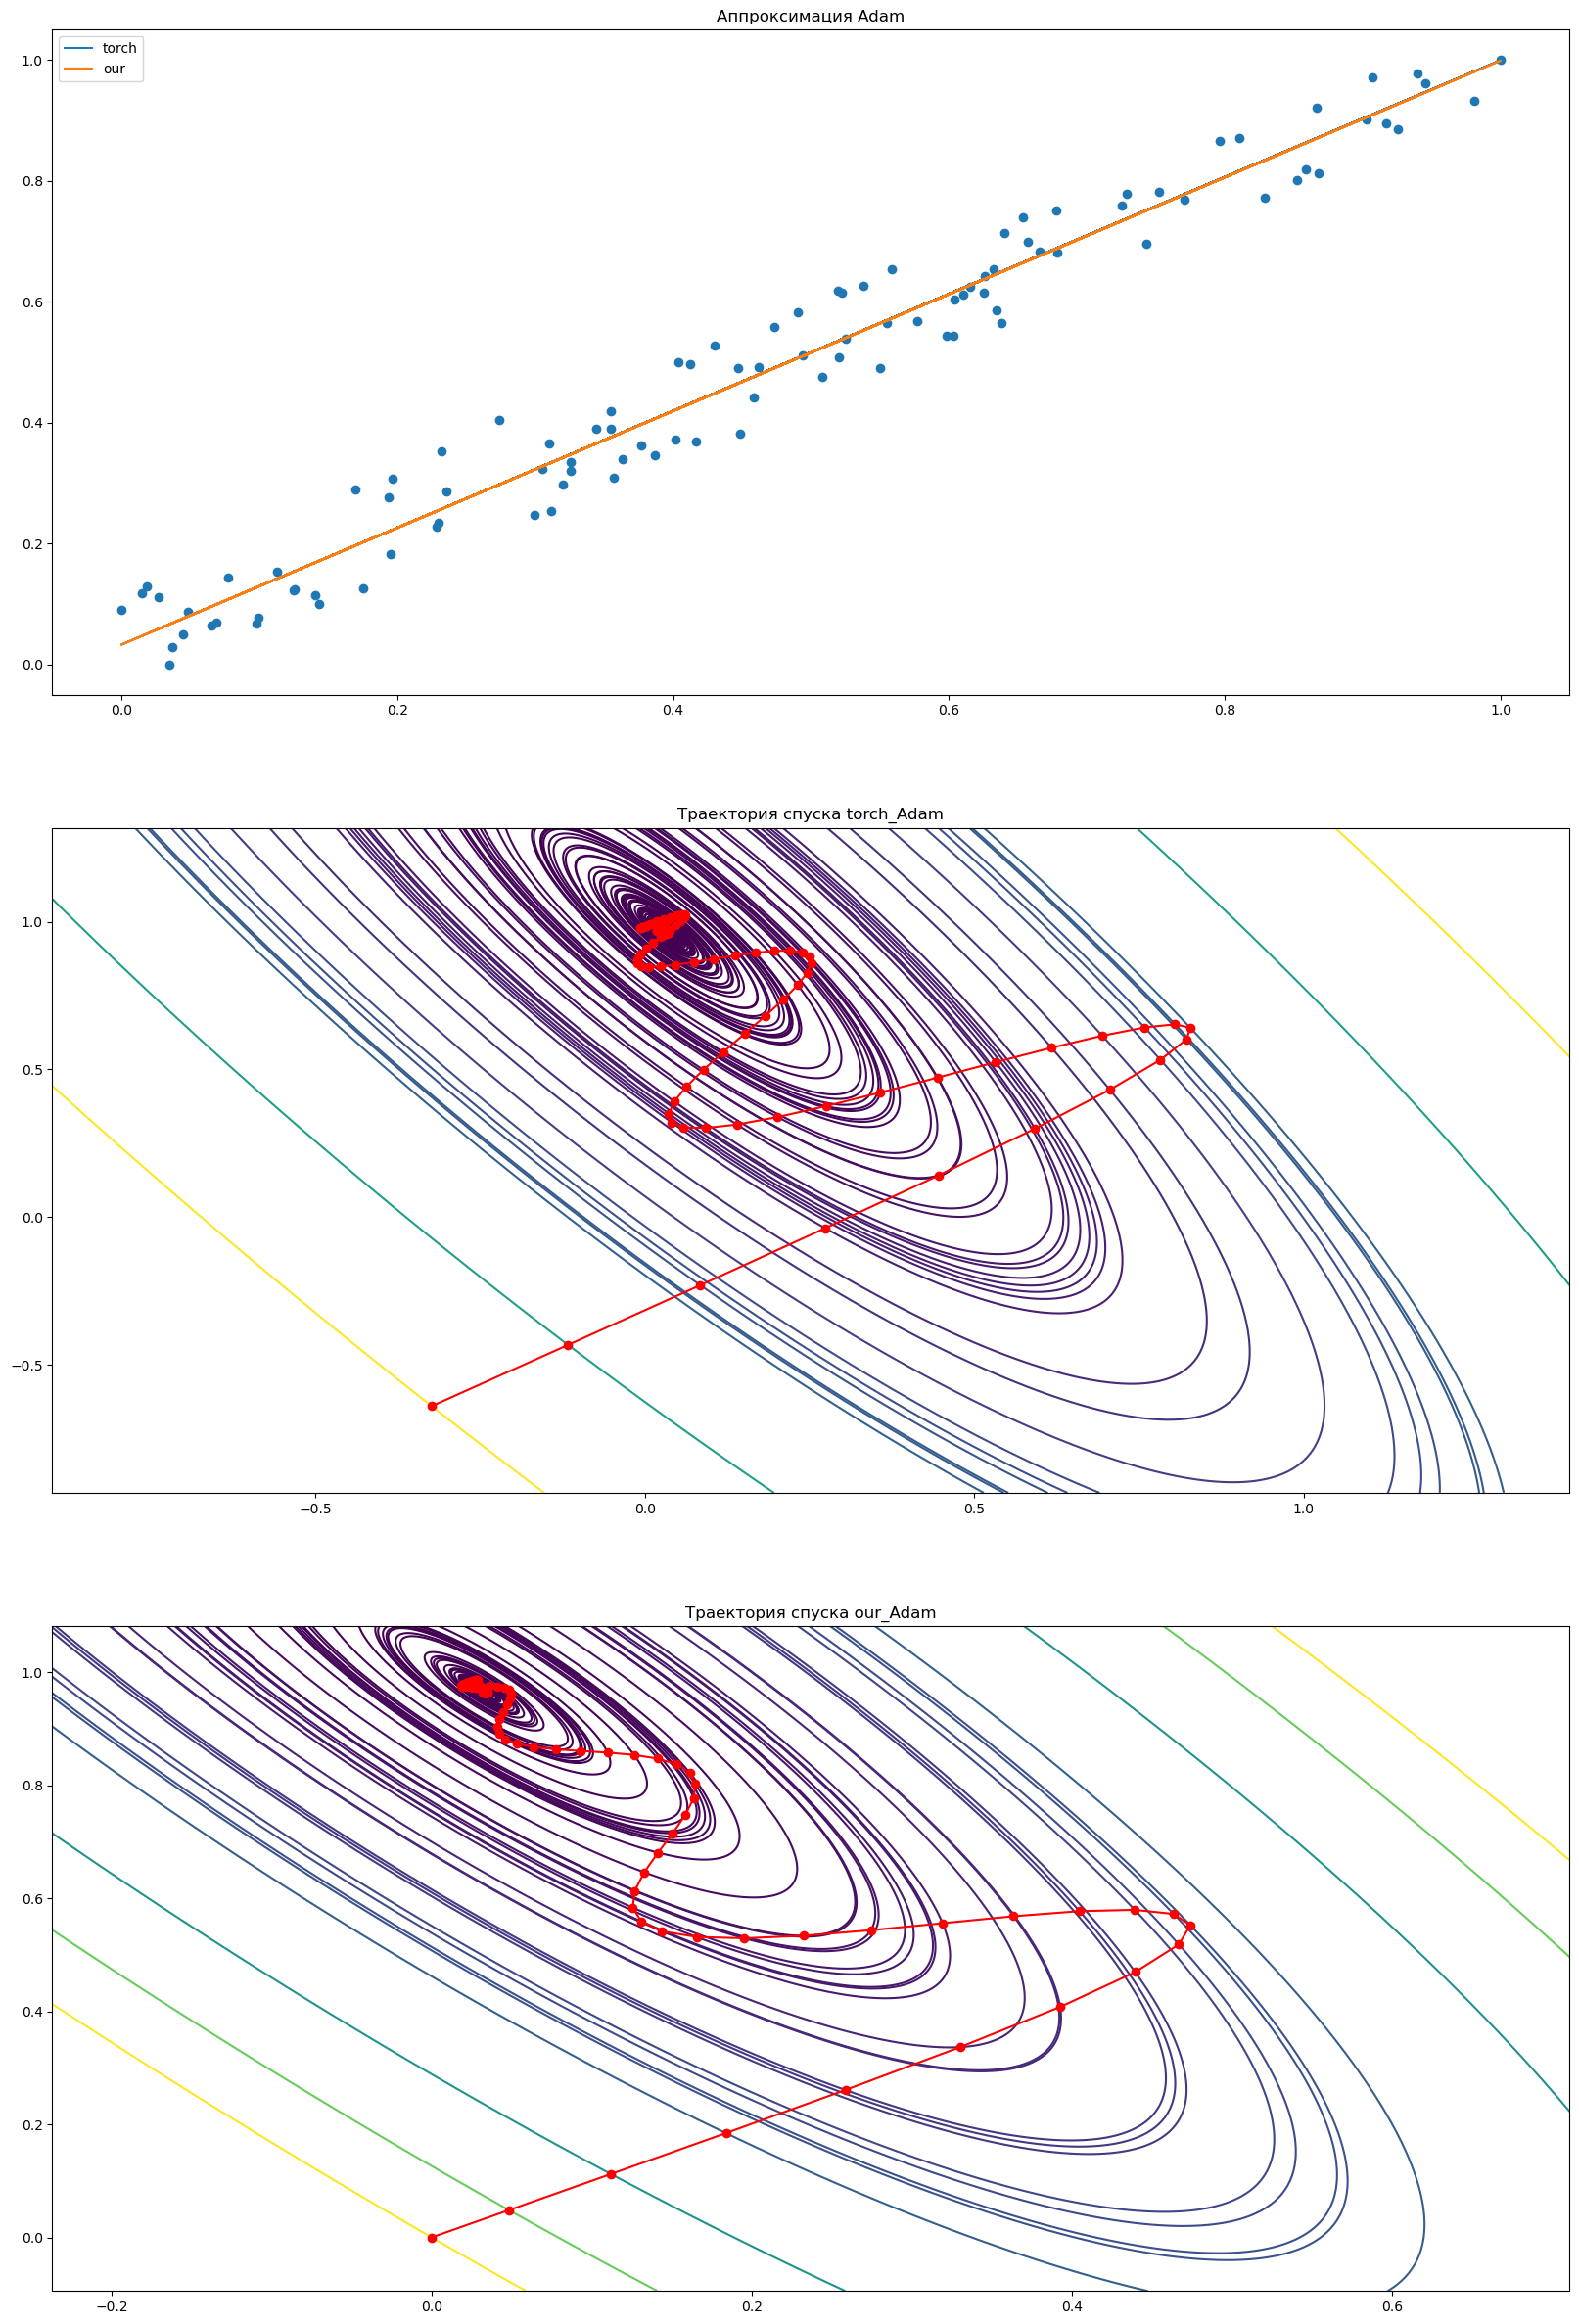

In [1793]:
shared_lr = 0.05
model = torch.nn.Linear(1, 1)
torch_adam_res = optimize(torch.optim.Adam(model.parameters(), lr = 0.21))
our_adam_res = sgd(np.array([0., 0.]), 0.069, Adam(0.86, 0.96), loss_func(x, y), 100, 100)
df_adam = compare_results(torch_adam_res, our_adam_res, "Adam")

In [1794]:
pd.concat([df_adagrad,df_rmsprop,df_adam]).reset_index(drop=True)

name  epochs                  loss
0  torch_AdaGrad      69 2.730778675886866e-01
1    our_AdaGrad     100 2.730742196657469e-01
2  torch_RMSProp      70 2.730772087526878e-01
3    our_RMSProp     197 2.757815938423936e-01
4     torch_Adam     150 2.730968349171516e-01
5       our_Adam     142 2.730741799393691e-01

Реализации SGD из библиотеки `PyTorch` в целом работают быстрее наших аналогов.

## Задание 3.  
Изучить использование готовых методов оптимизации из SciPy (scipy.optimize.minimize, scipy.optimize.least_squares)

---

Для метода `minimize` зададим функцию Розенброка, минимум которой мы и будем искать. Сразу же определим ее градиент (понадобится в пункте `b` для решения из прошлой лабы) и градиент, посчитанный через `PyTorch.autograd` (понадобится в пункте `a`).

In [1795]:
def rosenbrock(x):
    return (1 - x[0]) ** 2 + 100 * (x[1] - x[0] ** 2) ** 2

def rosenbrock_grad(x):
    return np.array([2 * (x[0] - 1) + 400 * x[0] * (x[0] ** 2 - x[1]), 200 * (x[1] - x[0] ** 2)])

def rosenbrock_torch_grad(x):
    x = torch.tensor(x, requires_grad=True)
    y = rosenbrock(x)
    y.backward()
    return x.grad

Для метода `least_squares` зададим полином, который будем искать и набор точек, по которым будем аппроксимировать полином. Также напишем функцию, считающую вычеты `residuals`, так как именно её от нас ожидает метод `scipy.optimize.least_squares`, и метод, считающий `jacobian` с помощью `PyTorch.autograd` (понадобится в пункте `a`). 

In [1796]:
cfs = [-22.5, -31.2, 8.8, 7.552, -1.2544, -0.43008, 0.073728]

def polynom_apply(x):
    def polynom(c):
        return c[0] + c[1] * x + c[2] * x ** 2 + c[3] * x ** 3 + c[4] * x ** 4 + c[5] * x ** 5 + c[6] * x ** 6
    return polynom

def residuals_apply(f, y):
    def residuals(c):
        return f(c) - y
    return residuals

x = np.linspace(-3.5, 5.5, 100)

polynom = polynom_apply(x)

y = polynom(cfs) + 5 * np.random.randn(len(x))

start = -np.ones(len(cfs))

def jac_polynom_torch_apply(xs):
    def jac_polynom_torch(c):
        res = []
        for xi in xs:
            cc = tuple(map(lambda ci: torch.tensor(ci, requires_grad=True), c))
            poly = polynom_apply(xi)
            yy = poly(cc)
            yy.backward()
            res.append([ci.grad for ci in cc])
        return np.array(res)
    return jac_polynom_torch

Для сбора статистики.

In [1797]:
data_minimize = []
minimize_columns = ["name", "nfev", "njev", "nit", "fun"]
data_least_squares = []
least_squares_columns = ["name", "nfev", "njev", "optimality", "cost"]

Для рисования аппроксимаций.

In [1798]:
def draw_func(c, title = ""):
    plot.scatter(x, y, label="point set", s=5)
    plot.plot(x, polynom(c), label="found function", color='red')
    plot.legend()
    plot.title(f"Аппроксимация с методом - \"{title}\"")
    plot.show()
    pass

Чтобы "изучить" методы из `SciPy.optimize`, разберемся, что из себя представляет результат такой оптимизации.  

Эксклюзивно для `scipy.optimize.minimize`:  
`nit` - Кол-во итераций алгроритма  
`hess_inv` - Обратный гессиан  
  
Для `scipy.optimize.least_squares`:  
`cost` - Значение функции ошибки на найденном решении  
`grad` - Градиент функции ошибки на найденном решении  
`optimality` - Оптимальность (точность) решения. На задачах без органичений (Constraints) равна `np.norm(gradient)`  
`active_mask` - Маска указывающая на работу Constraints для переменных (0 - ограничения не активны, 1 - ограниение на верхнюю границу, -1 - на нижнюю)  
  
Общее:  
`x` - Найденное решение  
`fun` - Значения остатков на найденном решении  
`jac` - Якобиан  
`nfev` - Кол-во исполнений переданной функции  
`njev` - Кол-во подсчетов якобиана  
`status` - Статус код алгорита (не `-1` уже обычно хорошо)  
`success` - Self-explanatory
`message` - Причина завершения

In [1799]:
min_rosenbrock_default = scipy.optimize.minimize(rosenbrock, np.zeros(2))
print(min_rosenbrock_default)

      fun: 2.8440316101421118e-11
 hess_inv: array([[0.49482454, 0.98957634],
       [0.98957634, 1.98394215]])
      jac: array([ 3.98673709e-06, -2.84416559e-06])
  message: 'Optimization terminated successfully.'
     nfev: 72
      nit: 19
     njev: 24
   status: 0
  success: True
        x: array([0.99999467, 0.99998932])


Запустили `scipy.optimize.minimize` на функции розенброка, и получили довольно точный минимум. Классно, работаем.

In [1800]:
ls_polynom_default = scipy.optimize.least_squares(residuals_apply(polynom, y), start)
print(f"cost = {ls_polynom_default.cost}")
print(f"nfev = {ls_polynom_default.nfev}")
print(f"njev = {ls_polynom_default.njev}")
print(f"optimality = {ls_polynom_default.optimality}")
print(f"x = {ls_polynom_default.x}")

cost = 1033.6073235228944
nfev = 7
njev = 7
optimality = 0.00018441588508721907
x = [-23.21533789 -32.43669987   9.57303763   7.84305795  -1.37075409
  -0.43905521   0.07698095]


`scipy.optimize.least_squares` хорошо работает, что тут сказать. Подробнее рассмотрим и сравним результаты после пункта `b` (когда уже будет что сравнивать.)

In [1801]:
#собираем инфу для сводной таблицы
data_minimize.append([
    "scipy_default",
    min_rosenbrock_default.nfev,
    min_rosenbrock_default.njev,
    min_rosenbrock_default.nit,
    min_rosenbrock_default.fun
    ])
data_least_squares.append([
    "scipy_default",
    ls_polynom_default.nfev,
    ls_polynom_default.njev,
    ls_polynom_default.optimality,
    ls_polynom_default.cost
    ])

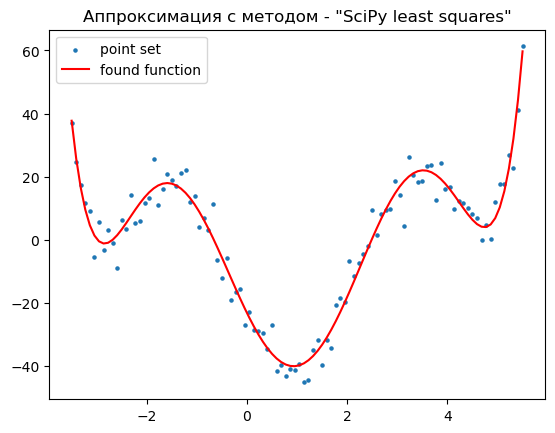

In [1802]:
draw_func(ls_polynom_default.x, "SciPy least squares")

### 3.a  
Рассмотреть возможность использования PyTorch для вычисления градиента

---

In [1803]:
min_rosenbrock_torch_jac = scipy.optimize.minimize(rosenbrock, np.zeros(2), jac=rosenbrock_torch_grad)
print(min_rosenbrock_torch_jac)

      fun: 7.717288356613562e-13
 hess_inv: array([[0.49480256, 0.98953879],
       [0.98953879, 1.98387918]])
      jac: array([ 3.92841201e-06, -2.83120873e-06])
  message: 'Optimization terminated successfully.'
     nfev: 24
      nit: 19
     njev: 24
   status: 0
  success: True
        x: array([0.99999913, 0.99999825])


Передавая в качестве Якобиана автоград из `PyTorch.autograd` мы уменьшили количество вызовов функции внутри поиска. 

In [1804]:
ls_polynom_torch_jac = scipy.optimize.least_squares(residuals_apply(polynom, y), start, jac=jac_polynom_torch_apply(x))
print(f"cost = {ls_polynom_torch_jac.cost}")
print(f"nfev = {ls_polynom_torch_jac.nfev}")
print(f"njev = {ls_polynom_torch_jac.njev}")
print(f"optimality = {ls_polynom_torch_jac.optimality}")
print(f"x = {ls_polynom_torch_jac.x}")

cost = 1033.6073235228932
nfev = 7
njev = 6
optimality = 9.233955367005109e-08
x = [-23.21533733 -32.43669988   9.57303736   7.84305796  -1.37075407
  -0.43905521   0.07698095]


In [1805]:
#собираем данные
data_minimize.append([
    "scipy_torchgrad",
    min_rosenbrock_torch_jac.nfev,
    min_rosenbrock_torch_jac.njev,
    min_rosenbrock_torch_jac.nit,
    min_rosenbrock_torch_jac.fun
    ])


data_least_squares.append([
    "scipy_torchgrad",
    ls_polynom_torch_jac.nfev,
    ls_polynom_torch_jac.njev,
    ls_polynom_torch_jac.optimality,
    ls_polynom_torch_jac.cost
    ])

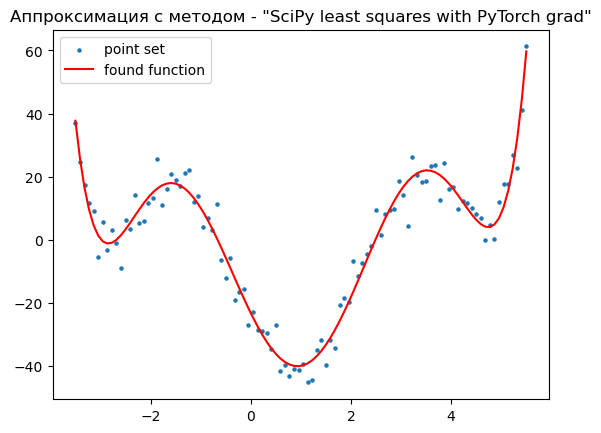

In [1806]:
draw_func(ls_polynom_torch_jac.x, "SciPy least squares with PyTorch grad")

### 3.b  
Исследовать эффективность и сравнить с собственными реализациями из 3 работы.  

---

Копипаста из третьей работы.

In [1807]:
def gauss_pinv(x):
    return np.linalg.pinv(x.T.dot(x)).dot(x.T)

def sum_quad_diff(f, y, c):
    return np.sum((f(c) - y) ** 2)

def jacobian(f, y, c, step):
    J = []
    y0 = f(c) - y

    for i in range(len(c)):

        new_x = c.copy()
        new_x[i] += step
        J.append((f(new_x) - y - y0) / step)

    return np.array(J).T

def gd(f, y, start, method, epochs=100, eps=1e-10):
    
    c = start.copy()
    error = np.inf
    diff = [sum_quad_diff(f, y, c)]
    
    for epoch in range(epochs):

        res = f(c) - y

        c -= method(jacobian(f, y, c, 1e-7)).dot(res)

        diff.append(sum_quad_diff(f, y, c))
        
        prev_error, error = error, np.sqrt(sum(res ** 2))
        if np.abs(prev_error - error) < eps:
            break

    return c, diff

def bfgs(f, df, start, epochs=100, eps=1e-8):
    cfs = start
    points = [cfs]

    I = np.eye(len(cfs))
    H = I.copy()
    
    gr = df(cfs)

    for epoch in range(epochs):
        p = - H.dot(gr)
        
        alpha = line_search(f, df, cfs, p, c1=1e-4, c2=0.9)[0]

        if alpha is None:
            s = 1e-4 * p
        else:
            s = alpha * p

        cfs = cfs + s
        points.append(cfs)

        ys = df(cfs) - gr
        gr = ys + gr
        
        if np.linalg.norm(gr) < eps:
            break

        ys = np.reshape(np.array([ys]), (len(cfs), 1))
        s = np.reshape(np.array([s]), (len(cfs), 1))

        r = 1. / (ys.T.dot(s))
        H = (I - r * s.dot(ys.T)).dot(H).dot((I - r * ys.dot(s.T))) + r * s.dot(s.T)

    return np.array(points)

In [1808]:
bfgs_points = bfgs(rosenbrock, rosenbrock_grad, np.zeros(2))
print(f"fun = {rosenbrock(bfgs_points[-1])}")
print(f"epochs = {len(bfgs_points)}")
print(f"x = {bfgs_points[-1]}")

fun = 9.686210813414849e-23
epochs = 21
x = [1. 1.]


In [1809]:
gauss_result, gauss_diffs = gd(polynom, y, start, gauss_pinv)
print(f"cost = {gauss_diffs[-1]}")
print(f"epochs = {len(gauss_diffs)}")
print(f"optimality = {gauss_diffs[-1] - gauss_diffs[-2]}")
print(f"x = {gauss_result}")

cost = 2067.2146470458333
epochs = 5
optimality = -4.3655745685100555e-11
x = [-23.2153373  -32.43670143   9.57303742   7.84305836  -1.37075411
  -0.43905524   0.07698096]


In [1810]:
#все еще собираем данные
data_least_squares.append([
    "our_gauss_newton",
    len(gauss_diffs),
    len(gauss_diffs),
    gauss_diffs[-1] - gauss_diffs[-2],
    gauss_diffs[-1]
    ])
data_minimize.append([
    "our_bfgs",
    len(bfgs_points),
    len(bfgs_points),
    len(bfgs_points),
    rosenbrock(bfgs_points[-1])
    ])

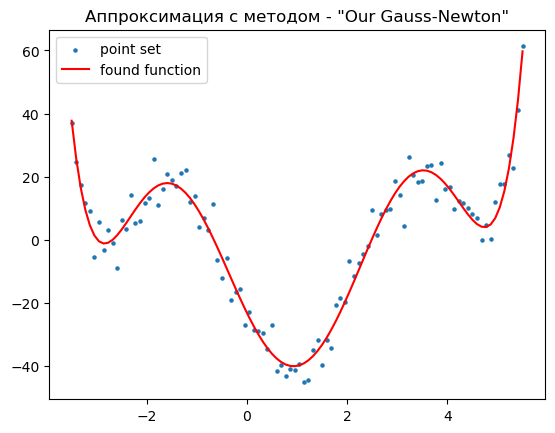

In [1811]:
draw_func(gauss_result, "Our Gauss-Newton")

#### Minimize

In [1812]:
pd.DataFrame(data_minimize,columns=minimize_columns)

name  nfev  njev  nit                   fun
0    scipy_default    72    24   19 2.844031610142112e-11
1  scipy_torchgrad    24    24   19 7.717288356613562e-13
2         our_bfgs    21    21   21 9.686210813414849e-23

Что у нас по ~~мобилизации~~ минимизации? `scipy.minimize` с `PyTorch.autograd` показывает себя лучше, чем дефолтный `scipy.minimize` почти по всем критериям. Однако нашей реализации `BFGS` из прошлой лабораторной удалось обогнать оба других метода. Почему? Например потому, что мы ей передаем готовую функцию градиента, посчитанную аналитически (я не знаю как еще это объяснить 🤡), а другие методы расчитывают на градиент, посчитанный автоматически. 

#### Least Squares

In [1813]:
pd.DataFrame(data_least_squares,columns=least_squares_columns)

name  nfev  njev             optimality                  cost
0     scipy_default     7     7  1.844158850872191e-04 1.033607323522894e+03
1   scipy_torchgrad     7     6  9.233955367005109e-08 1.033607323522893e+03
2  our_gauss_newton     5     5 -4.365574568510056e-11 2.067214647045833e+03

А что по методу наименьших квадратов? `scipy.least_squares` с `PyTorch.autograd` вызывает подсчет Якобиана меньше раз, чем `scipy.least_squares`. Что с функцией ошибки? Оба метода нашли минимум довольно быстро и довольно хорошо. Наша реализация метода Гаусса-Ньютона с прошлой лабы сработала быстрее, однако с функцией ошибки у неё не все в порядке.  
По рисункам выше видно, что аппроксимизация работает, и это уже хорошо.  

Что можно сказать насчет различных способов считать градиент? Написание функции вычисления градиента может помочь выиграть в точности и количестве вызовов. Но эта функция может получиться сложнее оригинальной и вычисление градиента будет стоить дороже. Автоградиент же более универсальный инструмент, хоть и может быть дорогой (так как вызывает дополнительный подсчет функции).

### 3.c  
Рассмотреть работу методов из SciPy при задании границ изменения для параметров.

---

In [1814]:
rosenbrock_bounds = scipy.optimize.Bounds(lb=(10., -np.inf), ub=(15., np.inf))

In [1815]:
print(scipy.optimize.minimize(rosenbrock, np.zeros(2), bounds = rosenbrock_bounds))

      fun: 81.00000000000001
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 1.80004434e+01, -1.42108636e-06])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 18
      nit: 3
     njev: 6
   status: 0
  success: True
        x: array([10.        , 99.99999999])


Границы влияют только на параметры и на содержащие их ограничения, однако сами по себе предоставляют лишь LowerBound (lb) и UpperBound (ub) для переменных.

## Задание 4.  
Изучить использование линейных и нелинейных ограничений в методах оптимизации (scipy.optimizescipy.optimize.LinearConstraint и scipy.optimizescipy.optimize.NonlinearConstraint).

---

В данной кофигурации для функции `f(x0 .. x2) = sin(x0) + (x1 - 11)^4 + (13 - x1 + x2)^2`, матрицей `A`, нижней границей `lb` и верхней - `ub` задаются следующие линейные ограничения:  
  
`inf >= x0 + x1 + 2x2 >= 3`  
`inf >= 2x0 - 3x1 + x2 >= -32`  
`inf >= 5x0 + 4x1 - x2 >= 60`  
`6 >= x0 >= 3`

In [1816]:
def f_lin_constr(x):
    return np.sin(x[0]) + (x[1] - 11) ** 4 + (13 - x[1] + x[2]) ** 2
    #MIN = 0 11 -2 
lin_const = scipy.optimize.LinearConstraint(
    np.array([[1., 1., 2.], [2., -3., 1.], [5., 4., -1.], [1., 0., 0.]]), #A
    np.array([3., -32., 60., 3.]), #lb
    np.array([np.inf, np.inf, np.inf, 6.]) #ub
    )

print(
    scipy.optimize.minimize(
        f_lin_constr,
        np.zeros(3),
        constraints=lin_const
        )
    )

     fun: -0.9999995377841941
     jac: array([ 1.00657344e-05, -2.19695270e-04,  5.51640987e-05])
 message: 'Optimization terminated successfully'
    nfev: 83
     nit: 20
    njev: 20
  status: 0
 success: True
       x: array([ 4.71239805, 10.97393292, -2.02604552])


Аналогичным образом задаются и нелинейные ограничения вида `ub >= nlc_func(x0 .. xn) >= lb`  
Можем использовать для задачи минимизации параметр `constraints`  
`constraints=(NLC(f1(x0..xn), lb1, ub1), NLC(f2(x0..xn), lb2, ub2), ...)`

In [1817]:
print(scipy.optimize.minimize(
        rosenbrock,
        np.zeros(2),
        constraints=scipy.optimize.NonlinearConstraint(lambda x: x[0] - np.sin(x[1]), -np.inf, 1.9)
))

     fun: 1.5784437734975424e-07
     jac: array([-0.00478985,  0.00201586])
 message: 'Optimization terminated successfully'
    nfev: 66
     nit: 20
    njev: 20
  status: 0
 success: True
       x: array([0.99961568, 0.99924158])


Использование различных способов ограничения переменных (Constraints + Bounds) позволяет рассматривать функции в желаемой области, помогает проводить посик конкретного минимума (при наличии нескольких) или "сузить" функцию по одной или нескольким переменным.